## Initialization Notebook

#### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class Task:
    def __init__(self, x, y):
        self.name = "Task"
        self.x = x
        self.y = y
        self.reward = np.random.randint(0, 100)

    def __str__(self):
        return f"Task at ({self.x}, {self.y})"

    def __repr__(self):
        return f"Task at ({self.x}, {self.y}) with reward {self.reward}"
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
# Robot class with random position and speed initialization
class Robot:
    def __init__(self, grid_size):
        # Random x, y position within grid boundaries
        self.x = np.random.randint(0, grid_size[0])
        self.y = np.random.randint(0, grid_size[1])
        # Random speed between 0.5 and 1.0
        self.speed = np.random.uniform(0.5, 1.0)

    def __repr__(self):
        return f"Robot at ({self.x}, {self.y}) with speed {self.speed:.2f}"

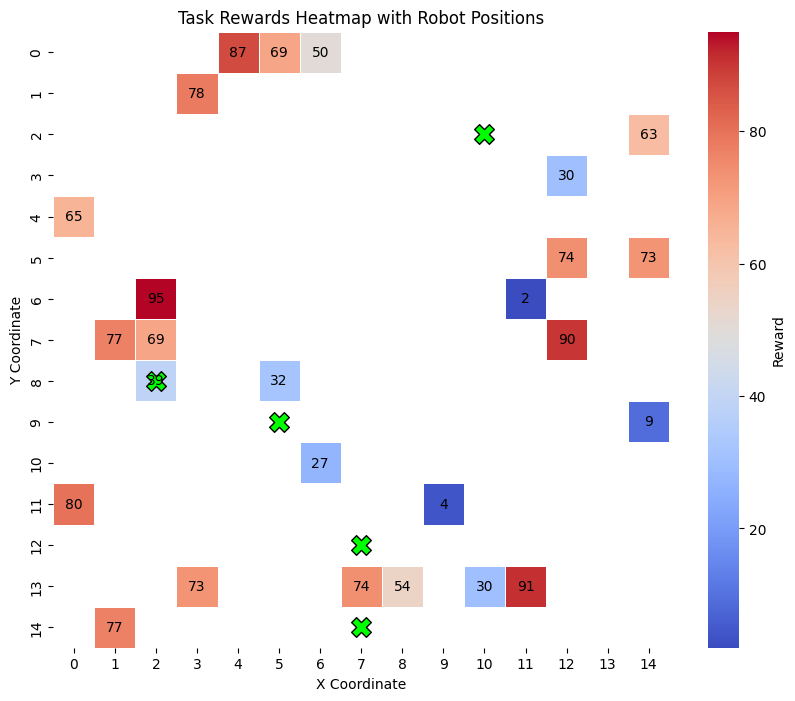

Robot at (9, 5) with speed 0.89
Robot at (2, 10) with speed 0.58
Robot at (8, 2) with speed 0.57
Robot at (12, 7) with speed 0.64
Robot at (14, 7) with speed 0.56


In [7]:
# Create a larger grid size
grid_size = (15, 15)  # Increase grid size to 15x15

# Create a list of tasks
tasks = [Task(np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1])) for _ in range(30)]

# Extract x, y, and rewards for tasks
x_vals = [task.x for task in tasks]
y_vals = [task.y for task in tasks]
rewards = [task.reward for task in tasks]

# Create a grid for the heatmap
reward_grid = np.zeros(grid_size)

# Populate the grid with rewards
for task in tasks:
    reward_grid[task.x, task.y] = task.reward

# Create a mask for cells where the reward is 0
mask = reward_grid == 0

# Initialize a list of robots
robots = [Robot(grid_size) for _ in range(5)]  # Example: 5 robots

# Plot the heatmap for tasks with rewards
plt.figure(figsize=(10, 8))
sns.heatmap(reward_grid, mask=mask, annot=True, fmt=".0f", cmap="coolwarm", 
            linewidths=0.5, square=True, cbar_kws={"label": "Reward"}, 
            annot_kws={"color": "black"})

# Overlay robots on the heatmap
for robot in robots:
    plt.scatter(robot.y + 0.5, robot.x + 0.5, color='lime', s=200, marker='X', edgecolors='black', label="Robot")

# To avoid clutter, ensure we only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
if len(handles) == 0:
    plt.legend(["Robot"], loc='upper right')

plt.title("Task Rewards Heatmap with Robot Positions")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Print robots and their initialized states
for robot in robots:
    print(robot)